In [1]:
# Bitcoin Market Sentiment & Trader Behavior Analysis - Colab Notebook

# 1. Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style="whitegrid")


In [2]:
# 2. Load datasets from GitHub raw URLs
sentiment_url = 'https://raw.githubusercontent.com/SahanaMathad/bitcoin-market-sentiment-ds-project/refs/heads/main/csvfiles/fear_greed_index.csv'
trader_url = 'https://raw.githubusercontent.com/SahanaMathad/bitcoin-market-sentiment-ds-project/refs/heads/main/csvfiles/historical_data.csv'

df_sent = pd.read_csv(sentiment_url)
df_trader = pd.read_csv(trader_url)

In [3]:
# 3. Data Parsing
df_sent['date'] = pd.to_datetime(df_sent['timestamp'], unit='s')
df_trader['Timestamp IST'] = pd.to_datetime(df_trader['Timestamp IST'], dayfirst=True)


In [4]:
# 4. Basic Data Checks
print(df_sent.info())
print(df_sent.head())

print(df_trader.info())
print(df_trader.head())

print("Sentiment missing:\n", df_sent.isnull().sum())
print("Trader missing:\n", df_trader.isnull().sum())

print("Sentiment duplicates:", df_sent.duplicated().sum())
print("Trader duplicates:", df_trader.duplicated().sum())

df_sent.drop_duplicates(inplace=True)
df_trader.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       2644 non-null   int64         
 1   value           2644 non-null   int64         
 2   classification  2644 non-null   object        
 3   date            2644 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 82.8+ KB
None
    timestamp  value classification                date
0  1517463000     30           Fear 2018-02-01 05:30:00
1  1517549400     15   Extreme Fear 2018-02-02 05:30:00
2  1517635800     40           Fear 2018-02-03 05:30:00
3  1517722200     24   Extreme Fear 2018-02-04 05:30:00
4  1517808600     11   Extreme Fear 2018-02-05 05:30:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  

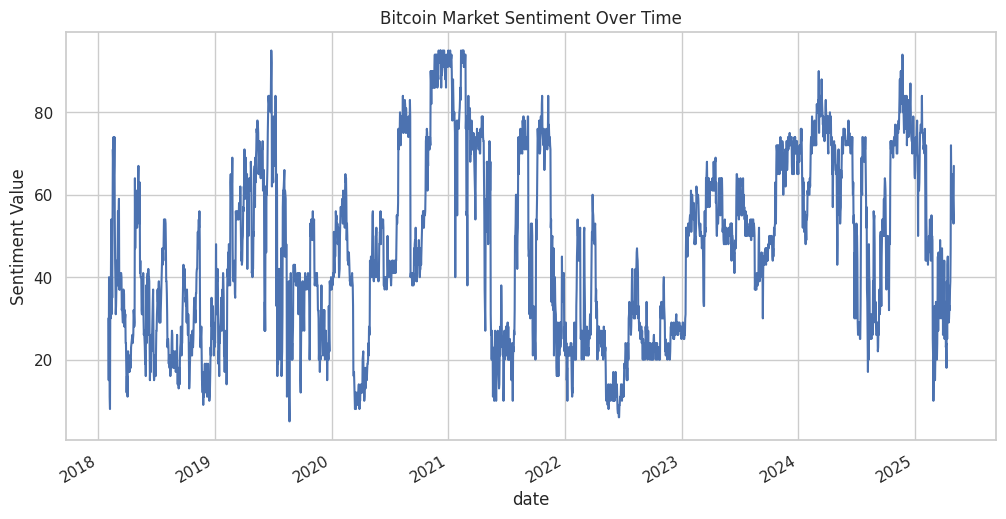

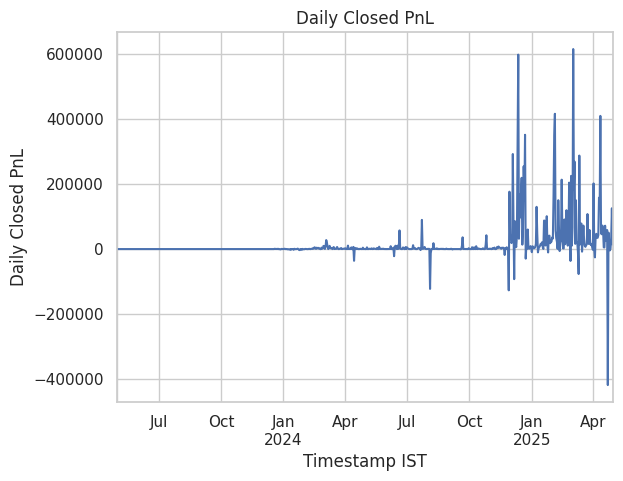

       Execution Price      Size USD     Closed PnL
count    211224.000000  2.112240e+05  211224.000000
mean      11414.723350  5.639451e+03      48.749001
std       29447.654868  3.657514e+04     919.164828
min           0.000005  0.000000e+00 -117990.104100
25%           4.854700  1.937900e+02       0.000000
50%          18.280000  5.970450e+02       0.000000
75%         101.580000  2.058960e+03       5.792797
max      109004.000000  3.921431e+06  135329.090100


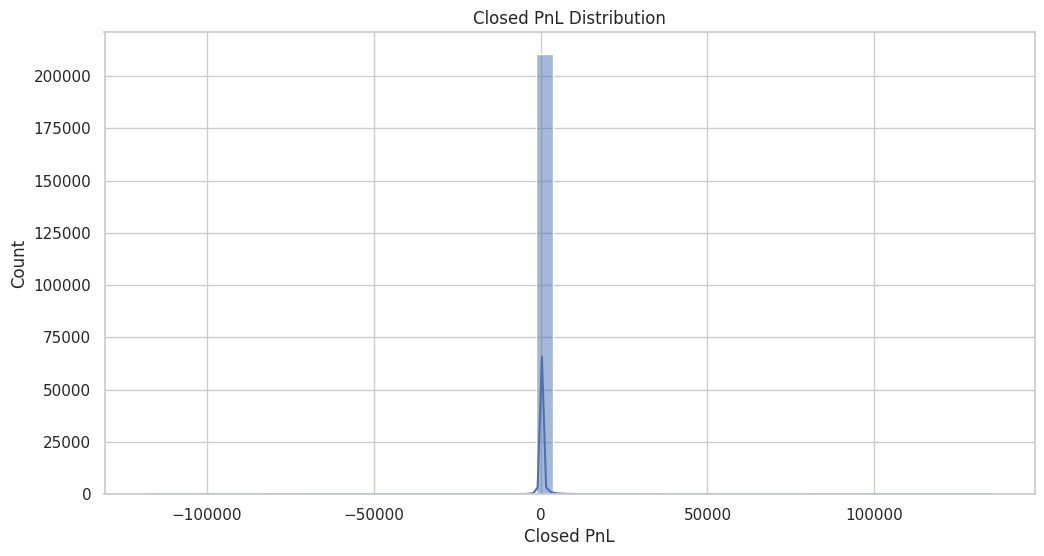

In [5]:
# 5. Exploratory Data Analysis
plt.figure(figsize=(12,6))
df_sent.set_index('date')['value'].plot(title='Bitcoin Market Sentiment Over Time')
plt.ylabel('Sentiment Value')
plt.savefig('/content/market_sentiment_over_time.png', bbox_inches='tight')
plt.show()

df_trader.resample('D', on='Timestamp IST')['Closed PnL'].sum().plot(title='Daily Closed PnL')
plt.ylabel('Daily Closed PnL')
plt.savefig('/content/daily_closed_pnl.png', bbox_inches='tight')
plt.show()

print(df_trader[['Execution Price', 'Size USD', 'Closed PnL']].describe())

plt.figure(figsize=(12,6))
sns.histplot(df_trader['Closed PnL'], bins=50, kde=True)
plt.title('Closed PnL Distribution')
plt.savefig('/content/closed_pnl_distribution.png', bbox_inches='tight')
plt.show()


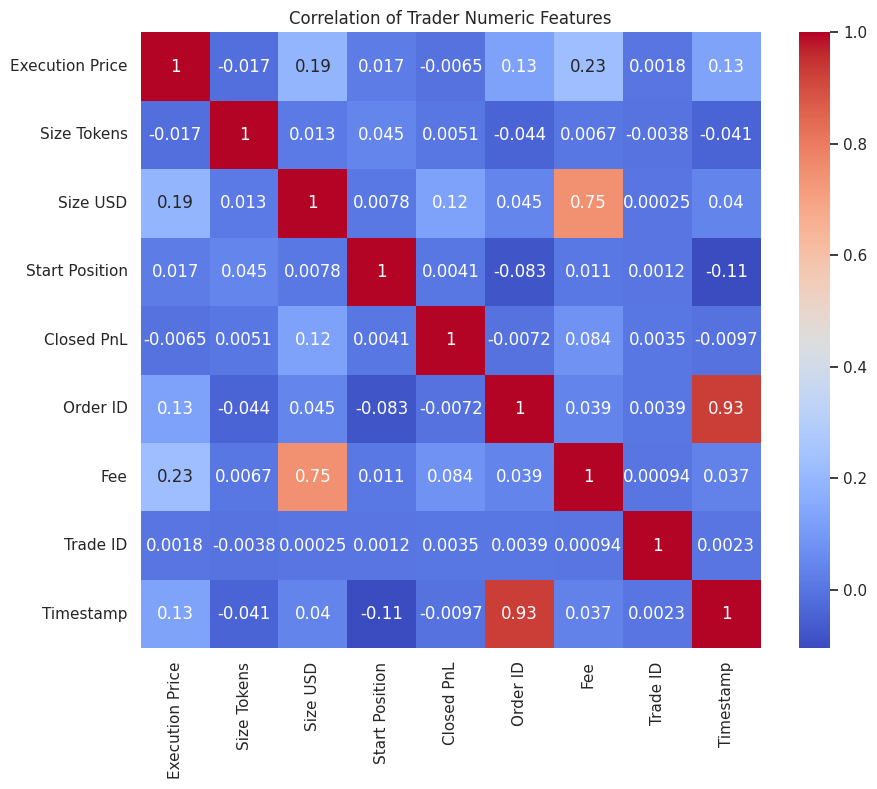

In [6]:
# Correlation matrix for numeric columns
numeric_cols = df_trader.select_dtypes(include=['number']).columns
plt.figure(figsize=(10,8))
sns.heatmap(df_trader[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation of Trader Numeric Features')
plt.savefig('/content/trader_features_correlation.png', bbox_inches='tight')
plt.show()

In [7]:
# 6. Feature Engineering
df_trader['PnL_per_USD'] = df_trader['Closed PnL'] / (df_trader['Size USD'] + 1)
df_trader['Trade_Hour'] = df_trader['Timestamp IST'].dt.hour
df_trader['Profit_Flag'] = df_trader['Closed PnL'] > 0

df_trader['Tokens_per_USD'] = df_trader['Size Tokens'] / (df_trader['Size USD'] + 1)
df_trader['Trade_Type'] = df_trader['Direction'] + "_" + df_trader['Side']


Number of Outliers Detected: 854


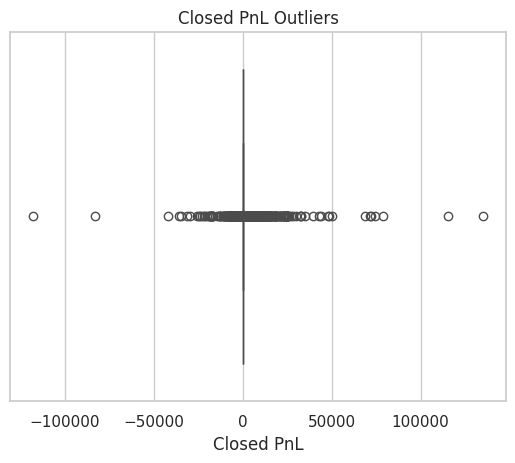

In [8]:
# Outlier detection for closed PnL
df_trader['Closed_PnL_zscore'] = zscore(df_trader['Closed PnL'])
outliers = df_trader[df_trader['Closed_PnL_zscore'].abs() > 3]
print(f"Number of Outliers Detected: {outliers.shape[0]}")

sns.boxplot(x=df_trader['Closed PnL'])
plt.title('Closed PnL Outliers')
plt.savefig('/content/closed_pnl_outliers.png', bbox_inches='tight')
plt.show()

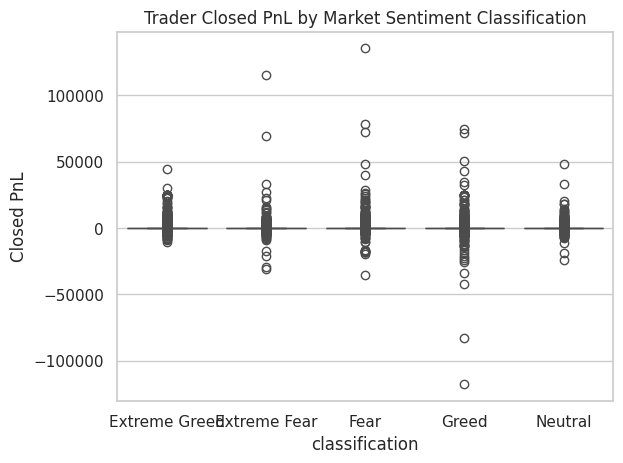

In [9]:
# 7. Merge sentiment with trader data for combined analysis
df_sent['day'] = df_sent['date'].dt.date
df_trader['trade_day'] = df_trader['Timestamp IST'].dt.date
df_merged = pd.merge(df_trader, df_sent, left_on='trade_day', right_on='day', how='left')

sns.boxplot(x='classification', y='Closed PnL', data=df_merged)
plt.title('Trader Closed PnL by Market Sentiment Classification')
plt.savefig('/content/pnl_by_sentiment.png', bbox_inches='tight')
plt.show()


In [10]:
# 8. Prepare features and labels for modeling
features = ['Execution Price', 'Size Tokens', 'Size USD', 'Fee', 'Trade_Hour', 'Coin', 'Side', 'Direction']
X = df_trader[features].copy()
y = df_trader['Profit_Flag']

# Encode categorical variables
for col in ['Coin', 'Side', 'Direction']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [11]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 9. Model Training & Evaluation
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.99      0.97      0.98     24802
        True       0.96      0.99      0.97     17443

    accuracy                           0.98     42245
   macro avg       0.97      0.98      0.98     42245
weighted avg       0.98      0.98      0.98     42245



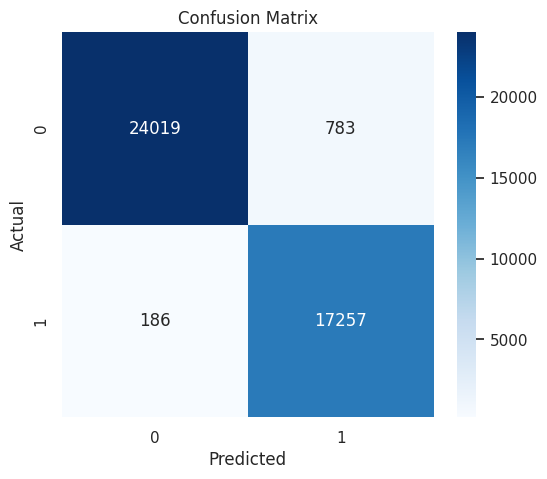

In [12]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('/content/confusion_matrix.png', bbox_inches='tight')
plt.show()

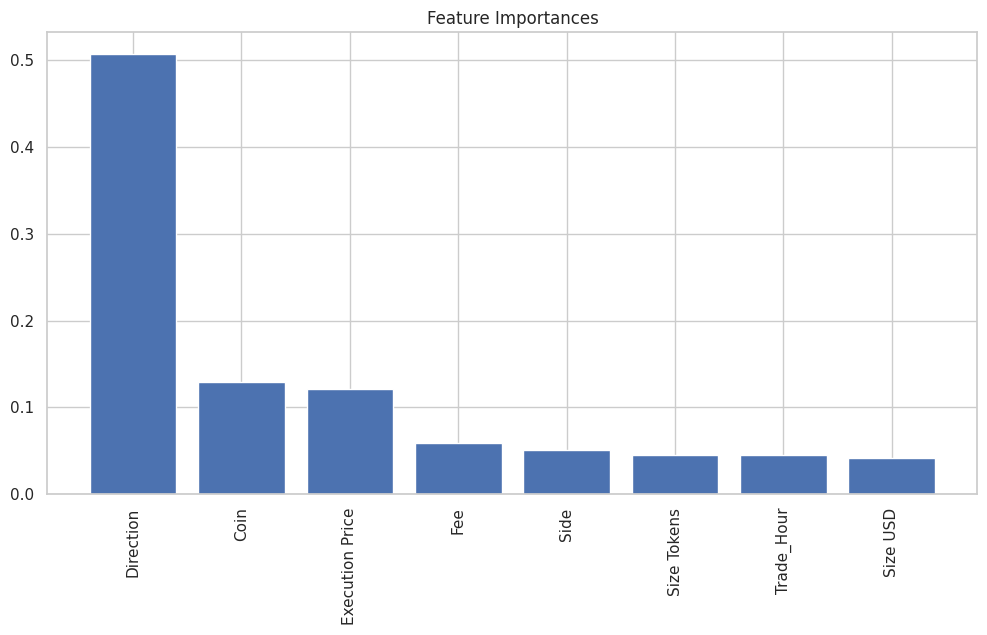

In [13]:
# Feature importance plot
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.savefig('/content/feature_importances.png', bbox_inches='tight')
plt.show()